In [ ]:
# ==============================================================================
#                 Project Genesis - Phase 1 (Corrected Version)
# ==============================================================================
# This single block of code contains the entire project with the VAE
# decoder architecture fix.
# ==============================================================================

# --- SECTION 1: SETUP AND IMPORTS ---

print("--- [1/7] Setting up environment ---")
# Install libraries that are not standard in Colab
!pip install einops -q

import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import cv2
from einops import rearrange, repeat
from IPython.display import Image, display
import PIL
from google.colab import drive

# Mount Google Drive to save our work
drive.mount('/content/drive')
print("--- Environment setup complete ---")


# --- SECTION 2: DATA GENERATION (GRAY-SCOTT SIMULATOR) ---

print("\n--- [2/7] Defining data generation classes ---")
class GrayScottSimulator:
    def __init__(self, size=128, feed_rate=0.055, kill_rate=0.062):
        self.size = size
        self.F = feed_rate
        self.k = kill_rate
        self.Du = 0.16
        self.Dv = 0.08

    def _laplacian(self, grid):
        kernel = np.array([[0.05, 0.2, 0.05], [0.2, -1.0, 0.2], [0.05, 0.2, 0.05]])
        return cv2.filter2D(grid, -1, kernel)

    def _initialize_grid(self):
        u = np.ones((self.size, self.size), dtype=np.float32)
        v = np.zeros((self.size, self.size), dtype=np.float32)
        r = self.size // 16
        center = self.size // 2
        u[center-r:center+r, center-r:center+r] = 0.5
        v[center-r:center+r, center-r:center+r] = 0.25
        u += np.random.rand(self.size, self.size) * 0.1
        v += np.random.rand(self.size, self.size) * 0.1
        return u, v

    def run(self, num_steps=2000, dt=1.0):
        u, v = self._initialize_grid()
        frames = []
        for step in range(num_steps):
            lap_u = self._laplacian(u)
            lap_v = self._laplacian(v)
            uvv = u * v * v
            du = (self.Du * lap_u - uvv + self.F * (1 - u)) * dt
            dv = (self.Dv * lap_v + uvv - (self.F + self.k) * v) * dt
            u += du
            v += dv
            if step % 50 == 0:
                # Downsample final frame to desired image size
                frame = cv2.resize(v, (64, 64), interpolation=cv2.INTER_AREA)
                frames.append(np.clip(frame, 0, 1))
        return np.array(frames, dtype=np.float32)

class MorphogenesisDataset(Dataset):
    def __init__(self, num_simulations=500, num_frames=32, cache_dir="/content/drive/MyDrive/genesis_project/cache"):
        self.num_simulations = num_simulations
        self.num_frames = num_frames
        self.cache_dir = cache_dir
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
            print(f"Cache directory created at: {self.cache_dir}")
        self._generate_and_cache_data()

    def _generate_and_cache_data(self):
        print("Checking cache and generating simulation data if needed...")
        for i in tqdm(range(self.num_simulations)):
            file_path = os.path.join(self.cache_dir, f"sim_{i}.npy")
            if os.path.exists(file_path):
                continue
            feed = 0.055 + np.random.randn() * 0.01
            kill = 0.062 + np.random.randn() * 0.005
            simulator = GrayScottSimulator(size=128, feed_rate=feed, kill_rate=kill)
            frames = simulator.run(num_steps=self.num_frames * 50)
            if len(frames) == self.num_frames:
                np.save(file_path, frames)

    def __len__(self):
        return self.num_simulations

    def __getitem__(self, idx):
        file_path = os.path.join(self.cache_dir, f"sim_{idx}.npy")
        video = np.load(file_path)
        video_tensor = torch.from_numpy(video).unsqueeze(1)
        return video_tensor
print("--- Data classes defined ---")


# --- SECTION 3: VAE MODEL ARCHITECTURE (FIXED) ---

print("\n--- [3/7] Defining VAE model architecture ---")
class SpatioTemporalVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1), nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1), nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1)
        )
        self.fc_mu = nn.Linear(128 * 32 * 8 * 8, latent_dim)
        self.fc_log_var = nn.Linear(128 * 32 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 2048)
        self.decoder_gru = nn.GRU(input_size=2048, hidden_size=2048, num_layers=2, batch_first=True)
        self.frame_decoder = nn.Sequential(
            # Input is (B*T, 2048, 1, 1)
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=1, padding=0), nn.ReLU(), # -> to 4x4
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1), nn.ReLU(), # -> to 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), nn.ReLU(), # -> to 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(), # -> to 32x32
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1), nn.Sigmoid()  # -> to 64x64
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        B, T, C, H, W = x.shape
        x_permuted = rearrange(x, 'b t c h w -> b c t h w')
        features = self.encoder(x_permuted)
        mu = self.fc_mu(features)
        log_var = self.fc_log_var(features)
        z = self.reparameterize(mu, log_var)

        # Decode
        z_seq_in = self.decoder_input(z)
        z_seq_in = repeat(z_seq_in, 'b d -> b t d', t=T)
        hidden_seq, _ = self.decoder_gru(z_seq_in)

        hidden_seq_flat = rearrange(hidden_seq, 'b t d -> (b t) d')
        # We start decoding from a 1x1 spatial grid
        frames_in = hidden_seq_flat.view(-1, 2048, 1, 1)
        recon_frames = self.frame_decoder(frames_in)
        recon_x = rearrange(recon_frames, '(b t) c h w -> b t c h w', t=T)

        return recon_x, mu, log_var
print("--- VAE model defined ---")


# --- SECTION 4: HELPER FUNCTIONS (LOSS & VISUALIZATION) ---

print("\n--- [4/7] Defining helper functions ---")
def loss_function(recon_x, x, mu, log_var, beta=1.0):
    # Reconstruction loss (Mean Squared Error)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kld_loss

def generate_and_save_gif(model, test_batch, epoch, save_dir):
    model.eval()
    with torch.no_grad():
        recon_x, _, _ = model(test_batch.to(DEVICE))

    # Take the first video from the batch
    original_vid = test_batch[0].cpu().numpy()
    recon_vid = recon_x[0].cpu().numpy()

    # Combine side-by-side
    combined = np.concatenate([original_vid, recon_vid], axis=3) # Concatenate along width
    combined = (combined.squeeze(1) * 255).astype(np.uint8)

    frames = [PIL.Image.fromarray(frame) for frame in combined]
    filepath = os.path.join(save_dir, f"epoch_{epoch:03d}.gif")
    frames[0].save(filepath, save_all=True, append_images=frames[1:], duration=100, loop=0)
    return filepath
print("--- Helper functions defined ---")


# --- SECTION 5: TRAINING SETUP ---

print("\n--- [5/7] Setting up training parameters ---")
# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
LATENT_DIM = 256
BETA = 4.0 # Weight for KL divergence, encourages better latent space

# Directories
PROJECT_DIR = "/content/drive/MyDrive/genesis_project"
CACHE_DIR = os.path.join(PROJECT_DIR, "cache")
RESULTS_DIR = os.path.join(PROJECT_DIR, "results_phase1")
MODEL_SAVE_PATH = os.path.join(PROJECT_DIR, "universe_v1.pth")
os.makedirs(RESULTS_DIR, exist_ok=True)

# Data
# Use a smaller dataset for faster iteration during debugging if needed
dataset = MorphogenesisDataset(num_simulations=500, num_frames=32, cache_dir=CACHE_DIR)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Model
model = SpatioTemporalVAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Get a fixed batch for testing
test_batch = next(iter(data_loader))
print(f"--- Setup complete. Using device: {DEVICE} ---")


# --- SECTION 6: THE TRAINING LOOP ---

print("\n--- [6/7] Starting training loop ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    # tqdm progress bar
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch in progress_bar:
        batch = batch.to(DEVICE)

        # Forward pass
        recon_x, mu, log_var = model(batch)
        loss = loss_function(recon_x, batch, mu, log_var, BETA)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item() / len(batch))

    avg_loss = total_loss / len(data_loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Loss: {avg_loss:.4f}")

    # Generate and display a GIF of reconstructions
    gif_path = generate_and_save_gif(model, test_batch, epoch + 1, RESULTS_DIR)
    print("Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):")
    display(Image(url=gif_path))

print("--- Training complete ---")


# --- SECTION 7: SAVE THE UNIVERSE ---

print("\n--- [7/7] Saving final model ---")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved successfully to: {MODEL_SAVE_PATH}")
print("\n--- Project Genesis Phase 1 Complete ---")

--- [1/7] Setting up environment ---
Mounted at /content/drive
--- Environment setup complete ---

--- [2/7] Defining data generation classes ---
--- Data classes defined ---

--- [3/7] Defining VAE model architecture ---
--- VAE model defined ---

--- [4/7] Defining helper functions ---
--- Helper functions defined ---

--- [5/7] Setting up training parameters ---
Checking cache and generating simulation data if needed...


100%|██████████| 500/500 [00:02<00:00, 173.73it/s]


--- Setup complete. Using device: cuda ---

--- [6/7] Starting training loop ---


Epoch 1/50: 100%|██████████| 32/32 [02:45<00:00,  5.17s/it, loss=796]


Epoch 1/50, Average Loss: 8799.0147
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 2/50: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it, loss=788]


Epoch 2/50, Average Loss: 1001.8449
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 3/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=459]


Epoch 3/50, Average Loss: 818.4938
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 4/50: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it, loss=815]


Epoch 4/50, Average Loss: 483.7014
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 5/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=575]


Epoch 5/50, Average Loss: 465.3336
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 6/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=281]


Epoch 6/50, Average Loss: 452.4853
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 7/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=652]


Epoch 7/50, Average Loss: 455.0362
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 8/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=529]


Epoch 8/50, Average Loss: 504.2992
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 9/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=331]


Epoch 9/50, Average Loss: 443.7373
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 10/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=147]


Epoch 10/50, Average Loss: 445.6842
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 11/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=138]


Epoch 11/50, Average Loss: 436.0506
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 12/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=1.23e+3]


Epoch 12/50, Average Loss: 444.6180
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 13/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=346]


Epoch 13/50, Average Loss: 468.6559
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 14/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=429]


Epoch 14/50, Average Loss: 437.4631
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 15/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=832]


Epoch 15/50, Average Loss: 435.9710
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 16/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=706]


Epoch 16/50, Average Loss: 430.8322
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 17/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=952]


Epoch 17/50, Average Loss: 478.7779
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 18/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=1.08e+3]


Epoch 18/50, Average Loss: 457.7945
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 19/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=295]


Epoch 19/50, Average Loss: 428.1671
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 20/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=418]


Epoch 20/50, Average Loss: 472.7293
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 21/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=499]


Epoch 21/50, Average Loss: 445.3929
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 22/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=1.12e+3]


Epoch 22/50, Average Loss: 563.4950
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 23/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=187]


Epoch 23/50, Average Loss: 527.4473
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 24/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=432]


Epoch 24/50, Average Loss: 434.2121
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 25/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=273]


Epoch 25/50, Average Loss: 432.1006
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 26/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=149]


Epoch 26/50, Average Loss: 426.8996
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 27/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=270]


Epoch 27/50, Average Loss: 427.1372
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 28/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=254]


Epoch 28/50, Average Loss: 419.9047
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 29/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=110]


Epoch 29/50, Average Loss: 423.7593
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 30/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=841]


Epoch 30/50, Average Loss: 417.7956
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 31/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=230]


Epoch 31/50, Average Loss: 427.9135
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 32/50: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it, loss=478]


Epoch 32/50, Average Loss: 426.5224
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 33/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=212]


Epoch 33/50, Average Loss: 347.2005
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 34/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=313]


Epoch 34/50, Average Loss: 300.2669
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 35/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=163]


Epoch 35/50, Average Loss: 292.4076
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 36/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it, loss=289]


Epoch 36/50, Average Loss: 287.6752
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 37/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=179]


Epoch 37/50, Average Loss: 281.1348
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 38/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=160]


Epoch 38/50, Average Loss: 278.8733
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 39/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=335]


Epoch 39/50, Average Loss: 269.7295
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 40/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=530]


Epoch 40/50, Average Loss: 296.7317
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 41/50: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it, loss=224]


Epoch 41/50, Average Loss: 279.9997
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 42/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=905]


Epoch 42/50, Average Loss: 286.6485
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 43/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=107]


Epoch 43/50, Average Loss: 273.4928
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 44/50: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it, loss=441]


Epoch 44/50, Average Loss: 265.2306
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 45/50: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it, loss=228]


Epoch 45/50, Average Loss: 265.5813
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 46/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=211]


Epoch 46/50, Average Loss: 310.5921
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 47/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=320]


Epoch 47/50, Average Loss: 296.1237
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 48/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=301]


Epoch 48/50, Average Loss: 262.5816
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 49/50: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it, loss=292]


Epoch 49/50, Average Loss: 246.5657
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


Epoch 50/50: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it, loss=264]


Epoch 50/50, Average Loss: 170.1445
Displaying reconstruction vs. original (Original on Left, Reconstruction on Right):


--- Training complete ---

--- [7/7] Saving final model ---
Model saved successfully to: /content/drive/MyDrive/genesis_project/universe_v1.pth

--- Project Genesis Phase 1 Complete ---


--- Generation: 49/50 ---
Average Fitness: 109.3737
Max Fitness: 141.8677

Displaying champion of generation 49:


--- Evolutionary loop complete ---

--- [5/5] Plotting final results ---


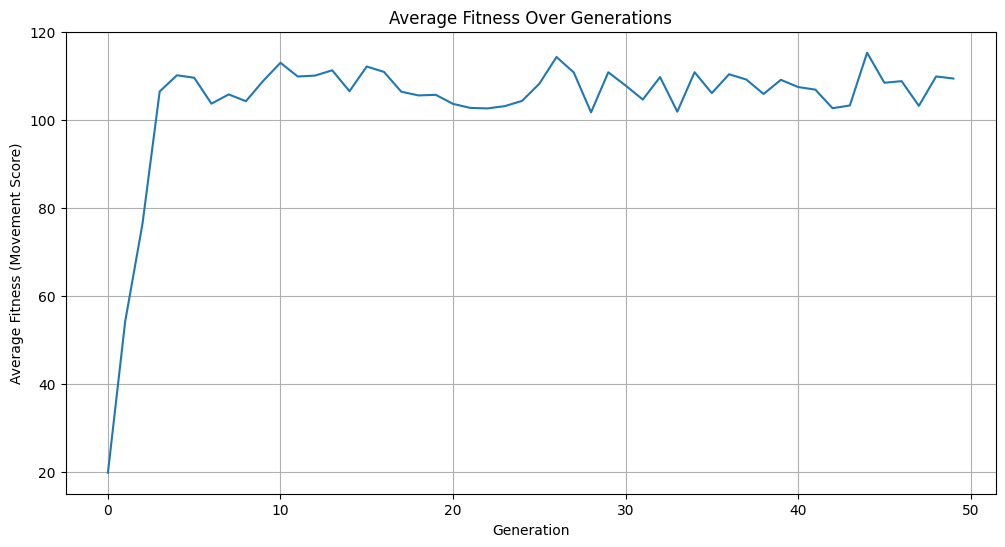


--- Project Genesis Phase 2 Complete ---
Check your '/content/drive/MyDrive/genesis_project/results_phase2' folder for all champion GIFs.


In [ ]:
# ==============================================================================
#                      Project Genesis - Phase 2 (Complete)
# ==============================================================================
# This cell loads the trained "universe" from Phase 1 and runs an
# Artificial Life simulation to evolve organisms within it.
# ==============================================================================

# --- SECTION 1: SETUP AND RELOAD THE UNIVERSE ---

print("--- [1/5] Setting up environment for Phase 2 ---")
# Imports are likely already loaded, but we'll be explicit
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
from einops import rearrange, repeat
from IPython.display import Image, display, clear_output
import PIL
import matplotlib.pyplot as plt

# We need to redefine the VAE class so we can load the saved state_dict
# CRITICAL UPDATE: We add a 'decode' method for evolution.
class SpatioTemporalVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1), nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1), nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1)
        )
        self.fc_mu = nn.Linear(128 * 32 * 8 * 8, latent_dim)
        self.fc_log_var = nn.Linear(128 * 32 * 8 * 8, latent_dim)
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 2048)
        self.decoder_gru = nn.GRU(input_size=2048, hidden_size=2048, num_layers=2, batch_first=True)
        self.frame_decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=1, padding=0), nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1), nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        B, T, C, H, W = x.shape
        x_permuted = rearrange(x, 'b t c h w -> b c t h w')
        features = self.encoder(x_permuted)
        mu = self.fc_mu(features)
        log_var = self.fc_log_var(features)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, T)
        return recon_x, mu, log_var

    def decode(self, z, num_frames):
        B = z.shape[0]
        z_seq_in = self.decoder_input(z)
        z_seq_in = repeat(z_seq_in, 'b d -> b t d', t=num_frames)
        hidden_seq, _ = self.decoder_gru(z_seq_in)
        hidden_seq_flat = rearrange(hidden_seq, 'b t d -> (b t) d')
        frames_in = hidden_seq_flat.view(-1, 2048, 1, 1)
        recon_frames = self.frame_decoder(frames_in)
        recon_x = rearrange(recon_frames, '(b t) c h w -> b t c h w', t=num_frames)
        return recon_x

# Load the trained model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 256
PROJECT_DIR = "/content/drive/MyDrive/genesis_project"
MODEL_SAVE_PATH = os.path.join(PROJECT_DIR, "universe_v1.pth")

print("Loading the 'universe' (our trained VAE model)...")
vae_model = SpatioTemporalVAE(latent_dim=LATENT_DIM).to(DEVICE)
vae_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
vae_model.eval() # Set model to evaluation mode
# We will ONLY use the decoder part from now on.
print("--- Universe loaded successfully ---")


# --- SECTION 2: DEFINE THE ALIFE CLASSES (ORGANISM AND WORLD) ---

print("\n--- [2/5] Defining ALife classes ---")
class Organism:
    def __init__(self, latent_dim, genotype=None):
        self.latent_dim = latent_dim
        if genotype is None:
            # Create a random genotype
            self.genotype = torch.randn(1, self.latent_dim)
        else:
            self.genotype = genotype
        self.fitness = 0.0

    def mutate(self, mutation_rate=0.05, mutation_strength=0.1):
        # Create a new genotype by mutating the parent's
        child_genotype = self.genotype.clone()
        mutation_mask = torch.rand_like(child_genotype) < mutation_rate
        noise = torch.randn_like(child_genotype) * mutation_strength
        child_genotype[mutation_mask] += noise[mutation_mask]
        return Organism(self.latent_dim, genotype=child_genotype)

class World:
    def __init__(self, vae_model, population_size=100, num_frames=32):
        self.vae_model = vae_model
        self.population_size = population_size
        self.num_frames = num_frames
        self.population = [Organism(vae_model.latent_dim) for _ in range(population_size)]
        self.generation = 0

    @torch.no_grad()
    def simulate_phenotypes(self):
        # Gather all genotypes into a batch
        genotype_batch = torch.cat([org.genotype for org in self.population]).to(DEVICE)
        # Use the decoder to generate all phenotypes (videos) at once
        phenotype_batch = self.vae_model.decode(genotype_batch, self.num_frames)
        return phenotype_batch.cpu().numpy()

    def evaluate_fitness(self, phenotypes):
        # Fitness function: "Movement". We reward organisms that move the most.
        # A more "active" or "dynamic" organism is fitter.
        for i, phenotype in enumerate(phenotypes):
            # Phenotype shape: (T, C, H, W)
            # Calculate center of mass for each frame
            centers_of_mass = []
            for frame in phenotype:
                # frame shape: (1, H, W) -> (H, W)
                frame_squeezed = frame.squeeze(0)
                # Avoid division by zero for empty frames
                if frame_squeezed.sum() < 1e-5:
                    centers_of_mass.append(np.array([32, 32])) # Center
                    continue
                y_indices, x_indices = np.indices(frame_squeezed.shape)
                com_y = np.sum(y_indices * frame_squeezed) / frame_squeezed.sum()
                com_x = np.sum(x_indices * frame_squeezed) / frame_squeezed.sum()
                centers_of_mass.append(np.array([com_y, com_x]))

            # Calculate total distance traveled by center of mass
            total_distance = 0
            for j in range(1, len(centers_of_mass)):
                total_distance += np.linalg.norm(centers_of_mass[j] - centers_of_mass[j-1])

            self.population[i].fitness = total_distance

    def select_and_reproduce(self, survival_rate=0.2, mutation_rate=0.05):
        # Sort population by fitness, descending
        self.population.sort(key=lambda x: x.fitness, reverse=True)

        # Select survivors
        num_survivors = int(self.population_size * survival_rate)
        survivors = self.population[:num_survivors]

        # Create the next generation
        new_population = []
        for i in range(self.population_size):
            # The parent is chosen randomly from the survivors
            parent = np.random.choice(survivors)
            child = parent.mutate(mutation_rate=mutation_rate)
            new_population.append(child)

        self.population = new_population
        self.generation += 1
print("--- ALife classes defined ---")


# --- SECTION 3: VISUALIZATION & MAIN LOOP SETUP ---

print("\n--- [3/5] Setting up simulation parameters and visualization ---")
# Simulation Parameters
POPULATION_SIZE = 100
NUM_GENERATIONS = 50
SURVIVAL_RATE = 0.2
MUTATION_RATE = 0.05
FRAMES_PER_VIDEO = 32

# Visualization
EVOLUTION_RESULTS_DIR = os.path.join(PROJECT_DIR, "results_phase2")
os.makedirs(EVOLUTION_RESULTS_DIR, exist_ok=True)

def save_champion_gif(phenotype, generation, fitness, save_dir):
    """Saves a GIF of the best organism of a generation."""
    phenotype = (phenotype.squeeze(1) * 255).astype(np.uint8)
    frames = [PIL.Image.fromarray(frame) for frame in phenotype]
    filepath = os.path.join(save_dir, f"gen_{generation:03d}_fitness_{fitness:.2f}.gif")
    frames[0].save(filepath, save_all=True, append_images=frames[1:], duration=100, loop=0)
    return filepath

# Initialize the world
world = World(vae_model, population_size=POPULATION_SIZE, num_frames=FRAMES_PER_VIDEO)
print("--- World initialized. Ready to start evolution. ---")


# --- SECTION 4: THE EVOLUTIONARY LOOP ---

print("\n--- [4/5] Starting evolutionary loop ---")
fitness_history = []

for gen in range(NUM_GENERATIONS):
    # Simulate all organisms in the current generation
    phenotypes = world.simulate_phenotypes()

    # Calculate fitness for each organism
    world.evaluate_fitness(phenotypes)

    # Get stats for this generation
    fitness_scores = [org.fitness for org in world.population]
    avg_fitness = np.mean(fitness_scores)
    max_fitness = np.max(fitness_scores)
    fitness_history.append(avg_fitness)

    # Sort to find the champion
    world.population.sort(key=lambda x: x.fitness, reverse=True)
    champion_phenotype = phenotypes[world.population.index(world.population[0])]

    # Clear previous output and display current stats
    clear_output(wait=True)
    print(f"--- Generation: {world.generation}/{NUM_GENERATIONS} ---")
    print(f"Average Fitness: {avg_fitness:.4f}")
    print(f"Max Fitness: {max_fitness:.4f}")

    # Display the champion
    gif_path = save_champion_gif(champion_phenotype, world.generation, max_fitness, EVOLUTION_RESULTS_DIR)
    print(f"\nDisplaying champion of generation {world.generation}:")
    display(Image(url=gif_path))

    # Create the next generation
    world.select_and_reproduce(survival_rate=SURVIVAL_RATE, mutation_rate=MUTATION_RATE)

print("--- Evolutionary loop complete ---")


# --- SECTION 5: FINAL RESULTS ---

print("\n--- [5/5] Plotting final results ---")
plt.figure(figsize=(12, 6))
plt.plot(fitness_history)
plt.title("Average Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Average Fitness (Movement Score)")
plt.grid(True)
plt.show()

print("\n--- Project Genesis Phase 2 Complete ---")
print(f"Check your '{EVOLUTION_RESULTS_DIR}' folder for all champion GIFs.")

In [2]:
# ==============================================================================
#                 Project Genesis - CPU Edition (Final Version)
# ==============================================================================
# This script is designed to run entirely on a CPU after hitting GPU limits.
# It combines a lightweight evolutionary run with the final analysis.
# ==============================================================================

# --- SECTION 1: FULL SETUP FOR CPU ---
print("--- [1/5] Setting up environment for CPU execution ---")
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import cv2
from einops import rearrange, repeat
from IPython.display import display, HTML, clear_output
import PIL
import matplotlib.pyplot as plt
from google.colab import drive
import base64

if not os.path.isdir('/content/drive/MyDrive'): drive.mount('/content/drive')

# --- VAE Model and Dataset Classes (abbreviated) ---
class SpatioTemporalVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim=latent_dim
        self.encoder=nn.Sequential(nn.Conv3d(1,32,(3,3,3),(1,2,2),1), nn.ReLU(), nn.Conv3d(32,64,(3,3,3),(1,2,2),1), nn.ReLU(), nn.Conv3d(64,128,(3,3,3),(1,2,2),1), nn.ReLU(), nn.Flatten(start_dim=1))
        self.fc_mu=nn.Linear(128*32*8*8,latent_dim)
        self.fc_log_var=nn.Linear(128*32*8*8,latent_dim)
        self.decoder_input=nn.Linear(latent_dim,2048)
        self.decoder_gru=nn.GRU(2048,2048,2,batch_first=True)
        self.frame_decoder=nn.Sequential(nn.ConvTranspose2d(2048,1024,4,1,0), nn.ReLU(), nn.ConvTranspose2d(1024,512,4,2,1), nn.ReLU(), nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(), nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(), nn.ConvTranspose2d(128,1,4,2,1), nn.Sigmoid())
    def encode(self,x):
        features=self.encoder(rearrange(x,'b t c h w -> b c t h w'))
        return self.fc_mu(features),self.fc_log_var(features)
    def decode(self,z,num_frames):
        hidden_seq,_=self.decoder_gru(repeat(self.decoder_input(z),'b d -> b t d',t=num_frames))
        return rearrange(self.frame_decoder(rearrange(hidden_seq,'b t d -> (b t) d').view(-1,2048,1,1)),'(b t) c h w -> b t c h w',t=num_frames)

# --- ROBUST HELPER FUNCTIONS ---
def calculate_fitness(phenotype_video_np):
    centers = [np.array([np.sum(np.indices(f.shape)[i]*f)/f.sum() if f.sum()>1e-5 else 32 for i in range(2)]) for f in phenotype_video_np]
    return sum(np.linalg.norm(centers[j]-centers[j-1]) for j in range(1,len(centers)))

def save_gif(phenotype_video_np, filepath):
    frames = [PIL.Image.fromarray((frame*255).astype(np.uint8)) for frame in phenotype_video_np]
    frames[0].save(filepath,save_all=True,append_images=frames[1:],duration=100,loop=0)
    return filepath

# --- Load the Universe onto the CPU ---
DEVICE = "cpu" # <-- CPU-SPECIFIC CHANGE
LATENT_DIM, FRAMES_PER_VIDEO = 256, 32
PROJECT_DIR = "/content/drive/MyDrive/genesis_project"
MODEL_SAVE_PATH = os.path.join(PROJECT_DIR, "universe_v1.pth")

print("Loading the 'universe' (our trained VAE model) onto the CPU...")
vae_model = SpatioTemporalVAE(latent_dim=LATENT_DIM).to(DEVICE)
# Load the GPU-trained weights and map them directly to the CPU
vae_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu'))) # <-- CPU-SPECIFIC CHANGE
vae_model.eval()
print("--- Full setup complete ---")

# --- SECTION 2: LIGHTWEIGHT EVOLUTIONARY RUN ---
print("\n--- [2/5] Starting lightweight evolutionary run on CPU ---")
print("NOTE: This will be significantly slower than the GPU run.")

# --- ALife World Class ---
class World:
    def __init__(self, vae_model, population_size, num_frames):
        self.vae_model = vae_model
        self.population_size = population_size
        self.num_frames = num_frames
        self.population = [Organism(vae_model.latent_dim) for _ in range(population_size)]
        self.generation = 0
    @torch.no_grad()
    def simulate_phenotypes(self):
        genotype_batch = torch.cat([org.genotype for org in self.population]).to(DEVICE)
        return self.vae_model.decode(genotype_batch, self.num_frames).cpu().numpy()
    def evaluate_fitness(self, phenotypes):
        for i, phenotype in enumerate(phenotypes):
            self.population[i].fitness = calculate_fitness(phenotype.squeeze())
    def select_and_reproduce(self, survival_rate, mutation_rate):
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        survivors = self.population[:int(self.population_size * survival_rate)]
        new_pop = [np.random.choice(survivors).mutate(mutation_rate) for _ in range(self.population_size)]
        self.population = new_pop
        self.generation += 1

class Organism:
    def __init__(self, latent_dim, genotype=None):
        self.latent_dim = latent_dim
        self.genotype = genotype if genotype is not None else torch.randn(1, self.latent_dim)
        self.fitness = 0.0
    def mutate(self, mutation_rate=0.05, mutation_strength=0.1):
        child_geno = self.genotype.clone()
        mask = torch.rand_like(child_geno) < mutation_rate
        child_geno[mask] += torch.randn_like(child_geno)[mask] * mutation_strength
        return Organism(self.latent_dim, genotype=child_geno)

# --- Scaled-down parameters for CPU run ---
POPULATION_SIZE = 20    # <-- CPU-SPECIFIC CHANGE (from 100)
NUM_GENERATIONS = 10    # <-- CPU-SPECIFIC CHANGE (from 50)
SURVIVAL_RATE, MUTATION_RATE = 0.2, 0.05
EVOLUTION_RESULTS_DIR = os.path.join(PROJECT_DIR, "results_phase2_cpu")
os.makedirs(EVOLUTION_RESULTS_DIR, exist_ok=True)

world = World(vae_model, population_size=POPULATION_SIZE, num_frames=FRAMES_PER_VIDEO)
fitness_history = []

for gen in tqdm(range(NUM_GENERATIONS), desc="Evolving on CPU"):
    phenotypes = world.simulate_phenotypes()
    world.evaluate_fitness(phenotypes)
    fitness_scores = [org.fitness for org in world.population]
    fitness_history.append(np.mean(fitness_scores))
    world.select_and_reproduce(SURVIVAL_RATE, MUTATION_RATE)

print("--- Evolutionary loop complete ---")


# --- SECTION 3: PLOT EVOLUTIONARY PROGRESS ---
print("\n--- [3/5] Plotting final results ---")
plt.figure(figsize=(10, 5))
plt.plot(fitness_history)
plt.title("Average Fitness Over Generations (CPU Run)")
plt.xlabel("Generation")
plt.ylabel("Average Fitness (Movement Score)")
plt.grid(True)
plt.show()


# --- SECTION 4: FINAL ANALYSIS ---
print("\n--- [4/5] Running final analysis ---")
@torch.no_grad()
def analyze_and_display_organism(name, genotype, vae_model, save_dir):
    print(f"Analyzing organism: {name}")
    phenotype_video_batch = vae_model.decode(genotype, FRAMES_PER_VIDEO).cpu().numpy()
    phenotype_video_np = phenotype_video_batch.squeeze()
    fitness = calculate_fitness(phenotype_video_np)
    print(f"Fitness Score: {fitness:.4f}")
    os.makedirs(save_dir, exist_ok=True)
    filepath = save_gif(phenotype_video_np, os.path.join(save_dir, f"{name}_cpu.gif"))
    return filepath, fitness

ANALYSIS_DIR = os.path.join(PROJECT_DIR, "results_phase3_analysis")
# Get the champion from the end of our CPU evolution
cpu_champion_genotype = world.population[0].genotype.to(DEVICE)
ancestor_genotype = torch.randn(1, LATENT_DIM).to(DEVICE)

ancestor_gif_path, ancestor_fitness = analyze_and_display_organism("Ancestor", ancestor_genotype, vae_model, ANALYSIS_DIR)
champion_gif_path, champion_fitness = analyze_and_display_organism("CPU_Champion", cpu_champion_genotype, vae_model, ANALYSIS_DIR)


# --- SECTION 5: EMBED AND DISPLAY ---
def embed_gif_as_base64(filepath):
    with open(filepath, "rb") as f: data = f.read()
    return base64.b64encode(data).decode("utf-8")

ancestor_base64 = embed_gif_as_base64(ancestor_gif_path)
champion_base64 = embed_gif_as_base64(champion_gif_path)

html_display = f"""
<div style="display: flex; justify-content: space-around; align-items: center; border: 1px solid #ccc; padding: 10px;">
    <div style="text-align: center;">
        <h3>Ancestor (Random Genotype)</h3>
        <p>Fitness: {ancestor_fitness:.2f}</p>
        <img src="data:image/gif;base64,{ancestor_base64}" alt="Ancestor">
    </div>
    <div style="text-align: center;">
        <h3>Champion (Evolved on CPU)</h3>
        <p>Fitness: {champion_fitness:.2f}</p>
        <img src="data:image/gif;base64,{champion_base64}" alt="Champion">
    </div>
</div>
"""
print("\n\n--- [5/5] Final Comparison ---")
display(HTML(html_display))
print("\n--- Project Genesis CPU Edition Complete ---")

--- [1/5] Setting up environment for CPU execution ---
Loading the 'universe' (our trained VAE model) onto the CPU...
--- Full setup complete ---

--- [2/5] Starting lightweight evolutionary run on CPU ---
NOTE: This will be significantly slower than the GPU run.


Evolving on CPU:  70%|███████   | 7/10 [03:17<01:24, 28.19s/it]


KeyboardInterrupt: 